In [1]:
from astropy.io import fits
from astropy import units, constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner 
from voigt_fit_lib import *
import os
import pickle
from scipy import interpolate

Load in the files

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/'

First, the FUV files

In [3]:
spec_fits_fuv = fits.open(rootdir + 'FUV/PG1522+101_FUV_wavecal_new.fits')
lsf_fits_fuv = fits.open(rootdir + 'FUV/PG1522_COS_FUV_wavcal2022_lsf_ZQ.fits')

Then, the NUV files

In [4]:
spec_fits_nuv = fits.open(rootdir + 'G185M/PG1522+101_NUV_wavecal_new.fits')
lsf_fits_nuv = fits.open(rootdir + 'G185M/PG1522_COS_NUV_wavcal2022_lsf.fits')

Then, the STIS files

In [5]:
spec_fits_stis = fits.open(rootdir + 'STIS/PG1522+101_E230M_new.fits')
lsf_fits_stis = fits.open(rootdir + 'STIS/PG1522_STIS_NUV_wavcal2022_lsf.fits')

Then, the HIRES files

In [6]:
spec_fits_hires = fits.open(rootdir + 'HIRES/PG1522+101_HIRES.fits')
lsf_fits_hires = fits.open(rootdir + 'HIRES/PG1522_HIRES_wavcal2023_lsf.fits')

Compile a list of the spectra, continuum nodes, and IDs for all detectors

In [7]:
spec_fits_list = [spec_fits_fuv, spec_fits_nuv, spec_fits_stis, spec_fits_hires]
lsf_fits_list = [lsf_fits_fuv, lsf_fits_nuv, lsf_fits_stis, lsf_fits_hires]

Systemic redshift

In [8]:
z_sys = 0.67545705

# CII 1036

In [9]:
cii_1036_fuv = ion_transition('CII', 1036, 'C', z_sys, 'FUV')

In [10]:
cii_1036_fuv.grab_ion_transition_info()

In [11]:
cii_1036_fuv.grab_ion_transition_spec(spec_fits_list)

In [12]:
cii_1036_fuv.cont_norm_flux(v_abs_range=[-100,100], degree=1)

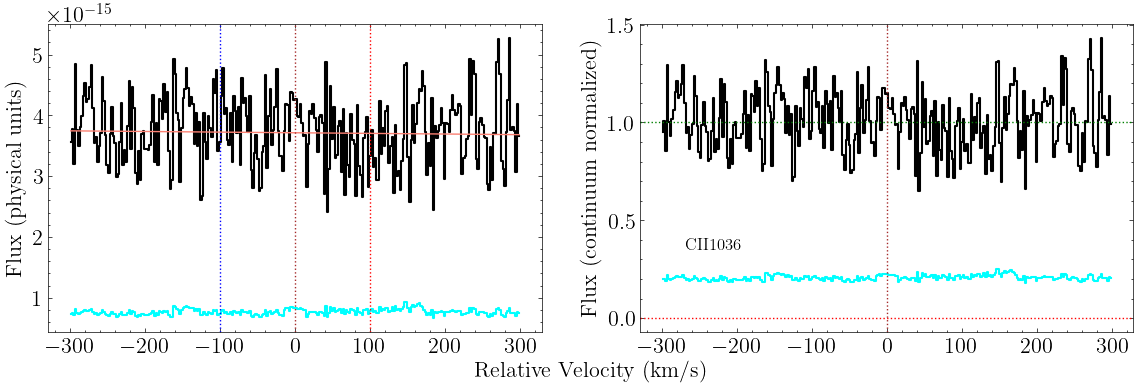

In [13]:
fig, axes = cii_1036_fuv.plot_ion_transition_spec_cont()

In [14]:
cii_1036_fuv.grab_ion_transition_lsf(lsf_fits_list)

Re-define variables

In [15]:
v = cii_1036_fuv.v
flux_obs = cii_1036_fuv.flux_norm
err_std = cii_1036_fuv.err_norm

In [16]:
b = 30

Define function for constructing a Voigt profile

In [17]:
def vp(v, logN, lsf_convolve=True):
    
    model = comp_model_spec_gen(v, np.array([[logN, b, 0]]), 
                                cii_1036_fuv.wav0_rest, cii_1036_fuv.f, cii_1036_fuv.gamma, cii_1036_fuv.A,
                                lsf_convolve,
                                cii_1036_fuv.lsf, cii_1036_fuv.v_lsf)[1]
    
    return model

Construct a mock profile to test convolution and measure the new FWHM

In [18]:
# Unconvolved and convolved profiles
mock_unconv = vp(v, 13, False)
mock_conv = vp(v, 13, True)

# Flux levels for FWHM in each profile
flux_fwhm_unconv = 1-0.5*(1-np.min(mock_unconv))
flux_fwhm_conv = 1-0.5*(1-np.min(mock_conv))

# Corresponding FWHM calculation
fwhm_unconv = 2*v[v>0][np.argmin(np.abs(mock_unconv[v>0]-flux_fwhm_unconv))]
fwhm_conv = 2*v[v>0][np.argmin(np.abs(mock_conv[v>0]-flux_fwhm_conv))]

In [19]:
np.sum(1-mock_conv), np.sum(1-mock_unconv)

(1.5038307567992766, 1.5043361326960927)

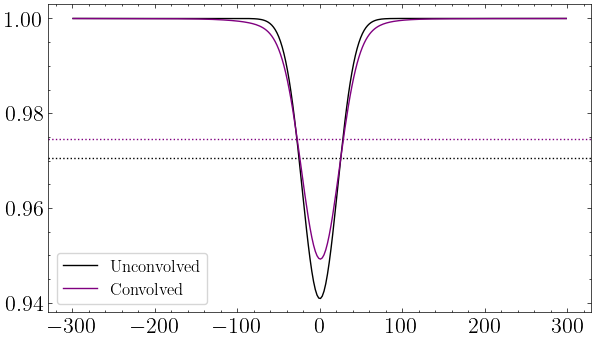

In [20]:
fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(v, mock_unconv, label='Unconvolved', color='black')
ax.axhline(flux_fwhm_unconv, color='black', linestyle=':')
ax.plot(v, mock_conv, label='Convolved', color='purple')
ax.axhline(flux_fwhm_conv, color='purple', linestyle=':')
ax.legend()

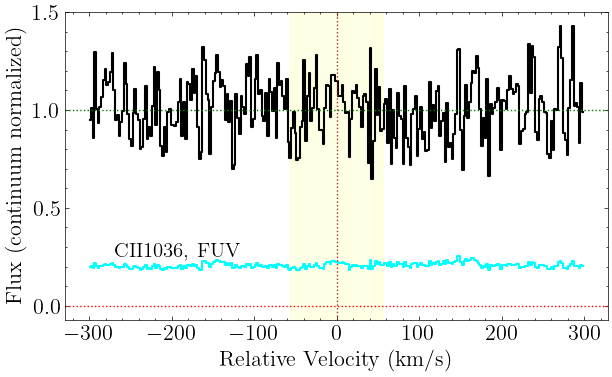

In [21]:
fig, ax = cii_1036_fuv.plot_ion_transition_spec()
ax.axvspan(xmin=-fwhm_conv, xmax=fwhm_conv, color='yellow', alpha=.1)

Generate noisy samples

In [22]:
idx = (v>-100)&(v<100) #(v>-fwhm_conv)&(v<fwhm_conv)

In [23]:
N_samples = 2000
noise_grid = np.zeros((N_samples, len(v)))

# For each spectral pixel
for k in range(len(v)):
    # Generate noise for all logN, for each trial
    noise_samples = np.random.normal(loc=1, scale=err_std[k], size=N_samples)
    # Save the reshaped noise in the larger grid
    noise_grid[:,k] = noise_samples

In [24]:
trials_indices = np.random.randint(low=0, high=N_samples, size=4)

Text(0, 0.5, 'Flux (continuum normalized)')

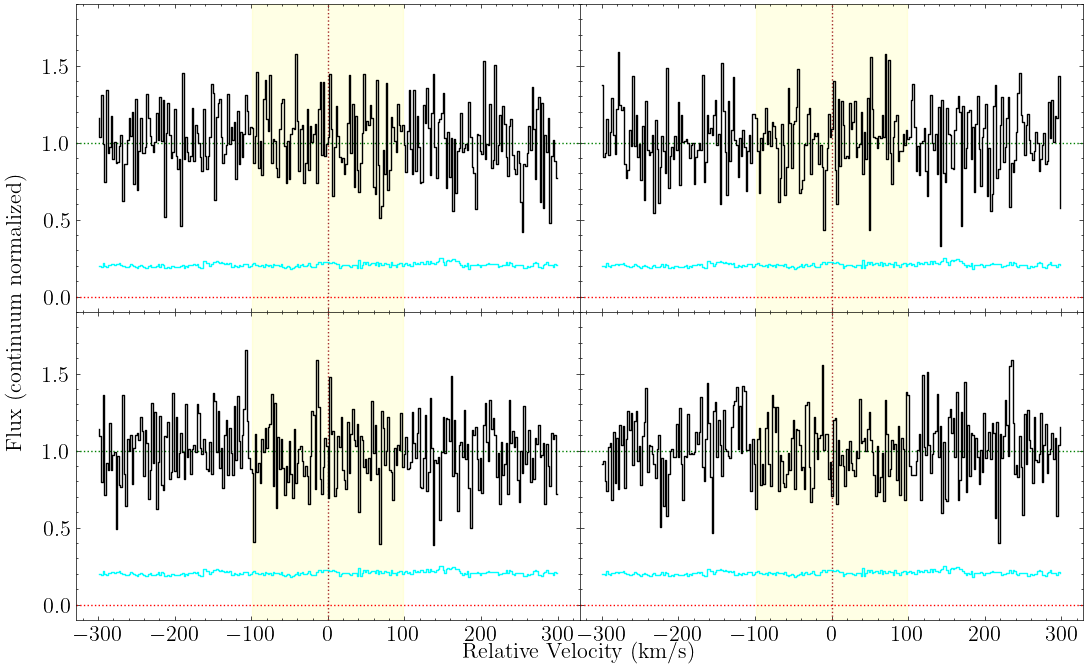

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(13,8), sharex=True, sharey=True)

axes[0,0].set_ylim(-0.1, 1.9)

for i in range(len(trials_indices)):
    
    ax = axes[i//2, i%2]
    ax.axvline(0, linestyle=':', color='brown')
    ax.axhline(0, linestyle=':', color='red')
    ax.axhline(1, linestyle=':', color='green')
    trial_idx = trials_indices[i]
    ax.step(v, noise_grid[trial_idx, :], where='mid')
    ax.step(v, err_std, where='mid', color='cyan')
    ax.axvspan(xmin=v[idx][0], xmax=v[idx][-1], color='yellow', alpha=.1)
    
plt.subplots_adjust(wspace=0, hspace=0)   

ax_label = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.set_xlabel('Relative Velocity (km/s)', labelpad=15) # Use argument `labelpad` to move label downwards.
ax_label.set_ylabel('Flux (continuum normalized)', labelpad=35)

Generate clean models

In [26]:
logN_grid = np.linspace(10.5, 14.0, 100) 

model_grid = np.zeros((len(logN_grid), len(v)))

for j in range(len(logN_grid)):
    model_grid[j,:] = vp(v, logN_grid[j])

Evaluate $\chi^2$ for each model

In [27]:
chi_sq_grid = np.zeros((N_samples, len(logN_grid)))

for i in range(N_samples):
    for j in range(len(logN_grid)):

        raw_spec = noise_grid[i,:][idx]
        model_spec = model_grid[j,:][idx]
        err_spec = err_std[idx]

        chi_sq_grid[i,j] = np.sum((raw_spec-model_spec)**2/err_spec**2)

Convert into PDF

In [28]:
pdf_grid = np.zeros((N_samples, len(logN_grid)))
cdf_grid = np.zeros((N_samples, len(logN_grid)))

for i in range(N_samples):
    for j in range(len(logN_grid)):
        pdf_grid[i,j] = np.exp(-0.5*chi_sq_grid[i,j])*10**logN_grid[j]
    pdf_grid[i,:] /= np.sum(pdf_grid[i,:])
    cdf_grid[i,:] = np.cumsum(pdf_grid[i,:])/np.sum(pdf_grid[i,:])

In [29]:
chi_sq_median = np.median(chi_sq_grid, axis=0)
pdf_median = np.exp(-0.5*chi_sq_median)*10**logN_grid
pdf_median /= np.sum(pdf_median)
cdf_median = np.cumsum(pdf_median)/np.sum(pdf_median)

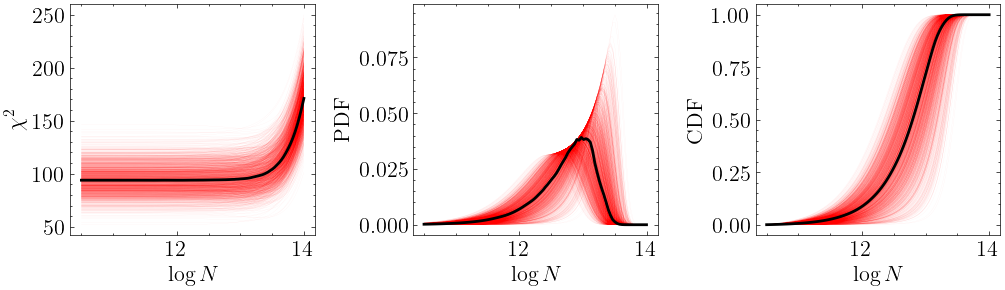

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(4*3,3))

for i in range(N_samples):
    axes[0].plot(logN_grid, chi_sq_grid[i,:], color='red', lw=.1, alpha=.1)
    
axes[0].plot(logN_grid, chi_sq_median, lw=2, color='black')

axes[0].set_xlabel(r'$\log N$')
axes[0].set_ylabel(r'$\chi^2$')

for i in range(N_samples):
    axes[1].plot(logN_grid, pdf_grid[i,:], color='red', lw=.1, alpha=.1)
    
axes[1].plot(logN_grid, pdf_median, lw=2, color='black')

axes[1].set_xlabel(r'$\log N$')
axes[1].set_ylabel(r'PDF')

for i in range(N_samples):
    axes[2].plot(logN_grid, cdf_grid[i,:], color='red', lw=.1, alpha=.1)
    
axes[2].plot(logN_grid, cdf_median, lw=2, color='black')

axes[2].set_xlabel(r'$\log N$')
axes[2].set_ylabel(r'CDF')

plt.subplots_adjust(wspace=0.4, hspace=0)   

Get upper limits from "median" PDF

In [31]:
from scipy.interpolate import interp1d

In [32]:
ppf_median = interp1d(cdf_median, logN_grid)

In [33]:
ppf_median([cdf_2sig])[0], ppf_median([cdf_3sig])[0]

(13.337587081757684, 13.492019727379327)

Get distribution of upper limits

In [34]:
from scipy.interpolate import interp1d

In [35]:
upper_lims_2sig = np.zeros(N_samples)
upper_lims_3sig = np.zeros(N_samples)

for i in range(N_samples):
    f = interp1d(cdf_grid[i,:], logN_grid)
    upper_lims_2sig[i] = f([cdf_2sig])[0]
    upper_lims_3sig[i] = f([cdf_3sig])[0]

In [36]:
np.median(upper_lims_2sig), np.median(upper_lims_3sig)

(13.22389549092643, 13.395846425337314)

Text(0, 0.5, 'PDF')

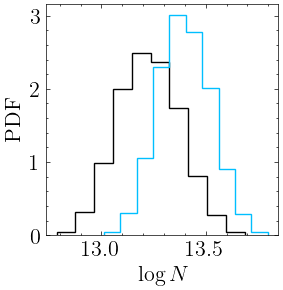

In [37]:
fig, ax = plt.subplots(1, figsize=(3,3))

ax.hist(upper_lims_2sig, histtype='step', label=r'$2\sigma$', density=True)
ax.hist(upper_lims_3sig, histtype='step', label=r'$3\sigma$', density=True)

ax.set_xlabel(r'$\log N$')
ax.set_ylabel('PDF')